In [82]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [84]:
DATA_PATH = '/content/drive/MyDrive/멀티캠퍼스_머신러닝/bike-sharing-demand/'
train = pd.read_csv(DATA_PATH + 'train.csv')
test = pd.read_csv(DATA_PATH + 'test.csv')
submission = pd.read_csv(DATA_PATH + 'sampleSubmission.csv')

In [85]:
train.head(1)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16


In [86]:
test.head(1)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027


In [87]:
submission.head(1)

,datetime,count
0,2011-01-20 00:00:00,0


## 탐색적 자료 분석
- datetime : 1시간 간격 데이터 수집
- season : 봄/여/가/겨 1,2,3,4
- holiday : 0 공휴일 아님, 1 공휴일
- workingday : 0 평일이 아님, 1: 평일
- weather : 1 맑음 2 약간 흐림 3 약한 눈,비 4 폭우, 폭설(기상이 매우 안좋은)   
.   
.   
- 종속 변수 : count(자전거 대여 수량)

## 문제 정의
- 각 시간대별로 자전거 대여 수량 예측하기

## 데이터 확인
- casual, registered 가 훈련데이터에 존재, 테스트 데이터에는 없는 상황

- casul : 비회원수
- registered : 회원수

## 날짜 데이터 변환(date time 속성일 때)
#### pd.to_datetime(train['datetime'])

.dt.year: 날짜 시리즈에서 연도를 추출합니다.

.dt.month: 날짜 시리즈에서 월을 추출합니다.

.dt.day: 날짜 시리즈에서 일(day)을 추출합니다.

.dt.weekday: 날짜 시리즈에서 요일을 추출합니다 (0은 월요일, 6은 일요일).

.dt.hour: 시간 시리즈에서 시(hour)를 추출합니다.

.dt.minute: 시간 시리즈에서 분(minute)을 추출합니다.

.dt.second: 시간 시리즈에서 초(second)를 추출합니다.

.dt.date(): 날짜 시리즈에서 날짜 부분만 추출하여 새로운 날짜 시리즈를 생성합니다.

.dt.time(): 시간 시리즈에서 시간 부분만 추출하여 새로운 시간 시리즈를 생성합니다.

.dt.strftime(): 날짜 및 시간 시리즈를 문자열 포맷으로 변환합니다.

In [88]:
# apply(lambda) 를 이용한 경우
train['date'] = train['datetime'].apply(lambda x : x.split()[0])
train['year'] =train['datetime'].apply(lambda x: x.split()[0].split('-')[0])
train['month'] =train['datetime'].apply(lambda x: x.split()[0].split('-')[1])
train['day'] =train['datetime'].apply(lambda x: x.split()[0].split('-')[2])
train['hour'] = train['datetime'].apply(lambda x: x.split()[1].split(':')[0])
train

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16,2011-01-01,2011,01,01,00
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40,2011-01-01,2011,01,01,01
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32,2011-01-01,2011,01,01,02
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13,2011-01-01,2011,01,01,03
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1,2011-01-01,2011,01,01,04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336,2012-12-19,2012,12,19,19
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241,2012-12-19,2012,12,19,20
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168,2012-12-19,2012,12,19,21
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129,2012-12-19,2012,12,19,22


In [89]:
from datetime import datetime
import calendar

sample_dt = train['date'][777] # 날짜
datetime.strptime(sample_dt, "%Y-%m-%d") # datetime 타입으로 변경하기
datetime.strptime(sample_dt, "%Y-%m-%d").weekday() # 정수로 요일값이 반환
calendar.day_name[datetime.strptime(sample_dt, "%Y-%m-%d").weekday()]

'Tuesday'

In [90]:
train['weekday'] = train['date'].apply(lambda x : calendar.day_name[datetime.strptime(x, "%Y-%m-%d").weekday()])
train.iloc[:, 11:]

,count,date,year,month,day,hour,weekday
0,16,2011-01-01,2011,01,01,00,Saturday
1,40,2011-01-01,2011,01,01,01,Saturday
2,32,2011-01-01,2011,01,01,02,Saturday
3,13,2011-01-01,2011,01,01,03,Saturday
4,1,2011-01-01,2011,01,01,04,Saturday
...,...,...,...,...,...,...,...
10881,336,2012-12-19,2012,12,19,19,Wednesday
10882,241,2012-12-19,2012,12,19,20,Wednesday
10883,168,2012-12-19,2012,12,19,21,Wednesday
10884,129,2012-12-19,2012,12,19,22,Wednesday


In [91]:
# season
train['season'] = train['season'].map({1: "봄", 2: "여름", 3:"가을", 4:"겨울"})

# weather
train['weather'] = train['weather'].map({1: "맑음", 2: "약간흐림", 3:"약한눈비", 4:"강한눈비"})

train

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,year,month,day,hour,weekday
0,2011-01-01 00:00:00,봄,0,0,맑음,9.84,14.395,81,0.0000,3,13,16,2011-01-01,2011,01,01,00,Saturday
1,2011-01-01 01:00:00,봄,0,0,맑음,9.02,13.635,80,0.0000,8,32,40,2011-01-01,2011,01,01,01,Saturday
2,2011-01-01 02:00:00,봄,0,0,맑음,9.02,13.635,80,0.0000,5,27,32,2011-01-01,2011,01,01,02,Saturday
3,2011-01-01 03:00:00,봄,0,0,맑음,9.84,14.395,75,0.0000,3,10,13,2011-01-01,2011,01,01,03,Saturday
4,2011-01-01 04:00:00,봄,0,0,맑음,9.84,14.395,75,0.0000,0,1,1,2011-01-01,2011,01,01,04,Saturday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,겨울,0,1,맑음,15.58,19.695,50,26.0027,7,329,336,2012-12-19,2012,12,19,19,Wednesday
10882,2012-12-19 20:00:00,겨울,0,1,맑음,14.76,17.425,57,15.0013,10,231,241,2012-12-19,2012,12,19,20,Wednesday
10883,2012-12-19 21:00:00,겨울,0,1,맑음,13.94,15.910,61,15.0013,4,164,168,2012-12-19,2012,12,19,21,Wednesday
10884,2012-12-19 22:00:00,겨울,0,1,맑음,13.94,17.425,61,6.0032,12,117,129,2012-12-19,2012,12,19,22,Wednesday


## 시각화 코드 작성
- count = 기울기x1 + x2 + x3

- 종속변수(=반응변수)가 제일 중요한 변수
- count는 고정된 값
  - count 수치 데이터를 기반으로한 시각화 종류 파악
  - 히스토그램 : count
  - 산점도 : y=count, x=수치형변수
  - 히트맵 : 수치형 X 수치형
  - 막대그래프~ 박스플롯~ 선그래프~ : x = 범주데이터, 날짜 / y = count

In [92]:
# 한글 폰트 적용하기 실행 후 런타임 재시작 필요.
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

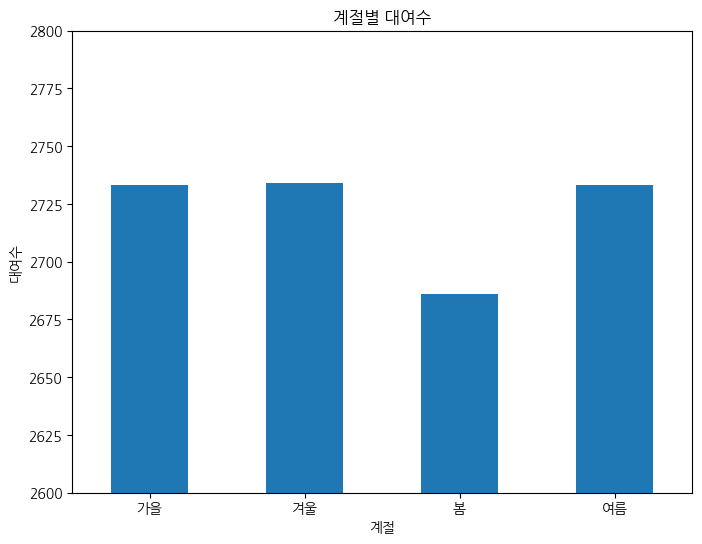

season
가을    2733
겨울    2734
봄     2686
여름    2733
dtype: int64


In [93]:
import matplotlib.pyplot as plt
from matplotlib import rc

# 나눔고딕 폰트 경로 설정
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'

# 폰트 설정
rc('font', family='NanumGothic')

# 그룹화 및 그룹별 데이터 개수 세기
grouped = train.groupby('season').size()

# 그래프 크기 설정
fig, ax = plt.subplots(figsize=(8, 6))

# 막대그래프 그리기
grouped.plot(kind='bar', ax=ax)
ax.set_title('계절별 대여수')
ax.set_xlabel('계절')
ax.set_ylabel('대여수')
ax.set_xticklabels(grouped.index, rotation=0)

# y축 범위 조정
ax.set_ylim(2600, 2800)

plt.show()
print(grouped)

## 탐색적 데이터 분석
- 머신러닝 진행할 때 왜 하는 걸까?
- 머신러닝
  - 예측을 하기 위한 방법론
- 최신 알고리즘이 있으니, 그거 쓰면 다 되는거 아냐?
- 시각화를 작성해서 얻고자 하는 목적!?  
.  
탐색적 데이터 분석 <= Feature Engineering 따라간다.  
.  
그러면 피처 엔지니어링? = 머신러닝 알고리즘에 적용할 독립변수를 찾아서 넣어주는 것

==> 미래 예측을 할 때, 필요한 독립변수는 최소 몇 개가 필요할까?

y = ax , 최소 1개만 있어도 가능은 함

### 내가 사용하려는 독립변수 X 컬럼이 정말 Y변수에 중요한 영향을 끼치는 변수일까?

### 여러 컬럼들이 중복될 수도 있고, 아니면 중요하지 않은 컬럼이 있을 수도 있고, 그러한 **컬럼들을 분류하고 적절하게 전처리를 하는 것**

아주 간단하게 머신러닝을 이해해보자면..   
어느날 어느 시의 count = 어느 날 어느 시의 a * season. b* holiday ... n * 변수   
또다른 어느날 어느 시의 count = 그 날의 a*season ...

### 그러면 각 독립변수의 기울기를 찾는 것이 머신러닝이고, 그 독립변수를 추리는 게 탐색적 데이터 분석인가요?   
정형데이터 컬럼이 존재하고(지금 우리 경우) 그걸 추리는 건 => 분석가의 도메인 지식 => **머신러닝!**    
비정형데이터(이미지, 영상, 음성) 그걸 추리는 건 => 알고리즘 => **딥러닝!**

<Axes: xlabel='count', ylabel='Count'>

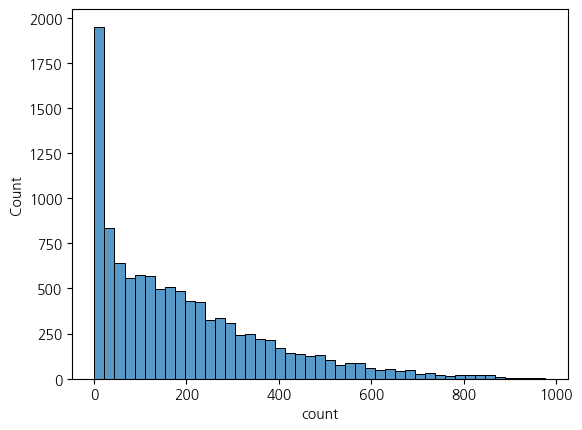

In [94]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
sns.histplot(train['count'])  # 아마 0건은 2000개 가까이 있고~ 의 느낌이라 count 값들이 각 몇 건이나 있는지 Count 한 히스토그램인듯

### 그래프를 봤을 때, 정규하지 않아서 => 로그변환(분석은 정규하다는 것을 전제하고 있으므로)\

<Axes: xlabel='count', ylabel='Count'>

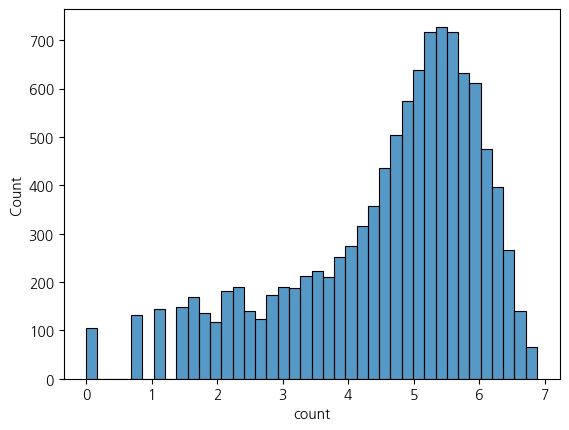

In [95]:
sns.histplot(np.log(train['count']))

### 첫번째 작업 완료
=> 종속 변수는 로그변환을 취해서 진행하기로 한다.  
=> 로그변환을 하고 예측을 하면, 로그변환된 값을 예측하는 것임을 양지  
=> 로그변환된 값을 지수변환으로 변경해서 최종 예측

# 막대 그래프

In [96]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,year,month,day,hour,weekday
0,2011-01-01 00:00:00,봄,0,0,맑음,9.84,14.395,81,0.0,3,13,16,2011-01-01,2011,01,01,00,Saturday
1,2011-01-01 01:00:00,봄,0,0,맑음,9.02,13.635,80,0.0,8,32,40,2011-01-01,2011,01,01,01,Saturday
2,2011-01-01 02:00:00,봄,0,0,맑음,9.02,13.635,80,0.0,5,27,32,2011-01-01,2011,01,01,02,Saturday
3,2011-01-01 03:00:00,봄,0,0,맑음,9.84,14.395,75,0.0,3,10,13,2011-01-01,2011,01,01,03,Saturday
4,2011-01-01 04:00:00,봄,0,0,맑음,9.84,14.395,75,0.0,0,1,1,2011-01-01,2011,01,01,04,Saturday


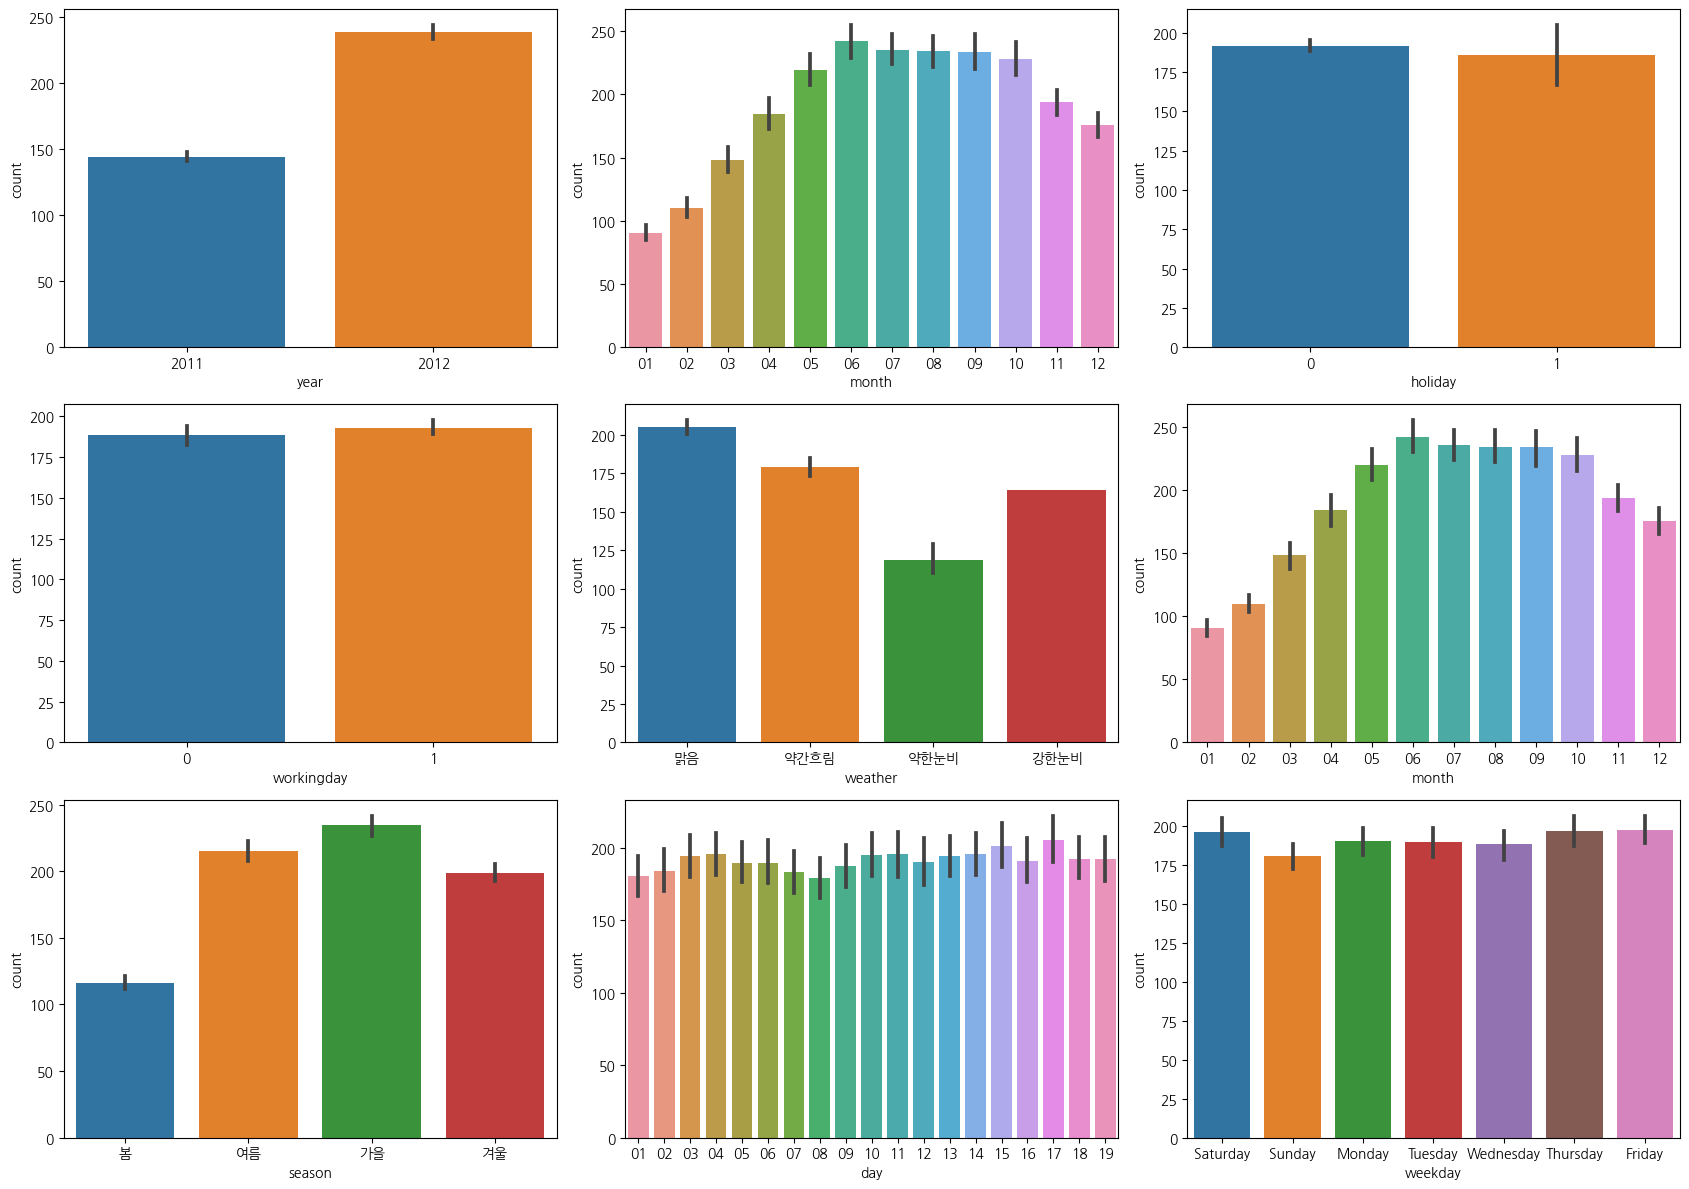

In [97]:
fig, ax = plt.subplots(nrows =3, ncols = 3, figsize=(17,12))
sns.barplot(x = 'year', y = 'count', data = train, ax = ax[0,0])
sns.barplot(x = 'month', y = 'count', data = train, ax = ax[0,1])
sns.barplot(x = 'holiday', y = 'count', data = train, ax = ax[0,2])
sns.barplot(x = 'workingday', y = 'count', data = train, ax = ax[1,0])
sns.barplot(x = 'weather', y = 'count', data = train, ax = ax[1,1])
sns.barplot(x = 'month', y = 'count', data = train, ax = ax[1,2])
sns.barplot(x = 'season', y = 'count', data = train, ax = ax[2,0])
sns.barplot(x = 'day', y = 'count', data = train, ax = ax[2,1])
sns.barplot(x = 'weekday', y = 'count', data = train, ax = ax[2,2])

plt.tight_layout()
plt.show()

## day 컬럼은 제거
- day 컬럼은 제외! 이유 train 1-19, test20-31 이라서!
  - 참조할만한 날짜가 훈련데이터에 존재하지 않음.

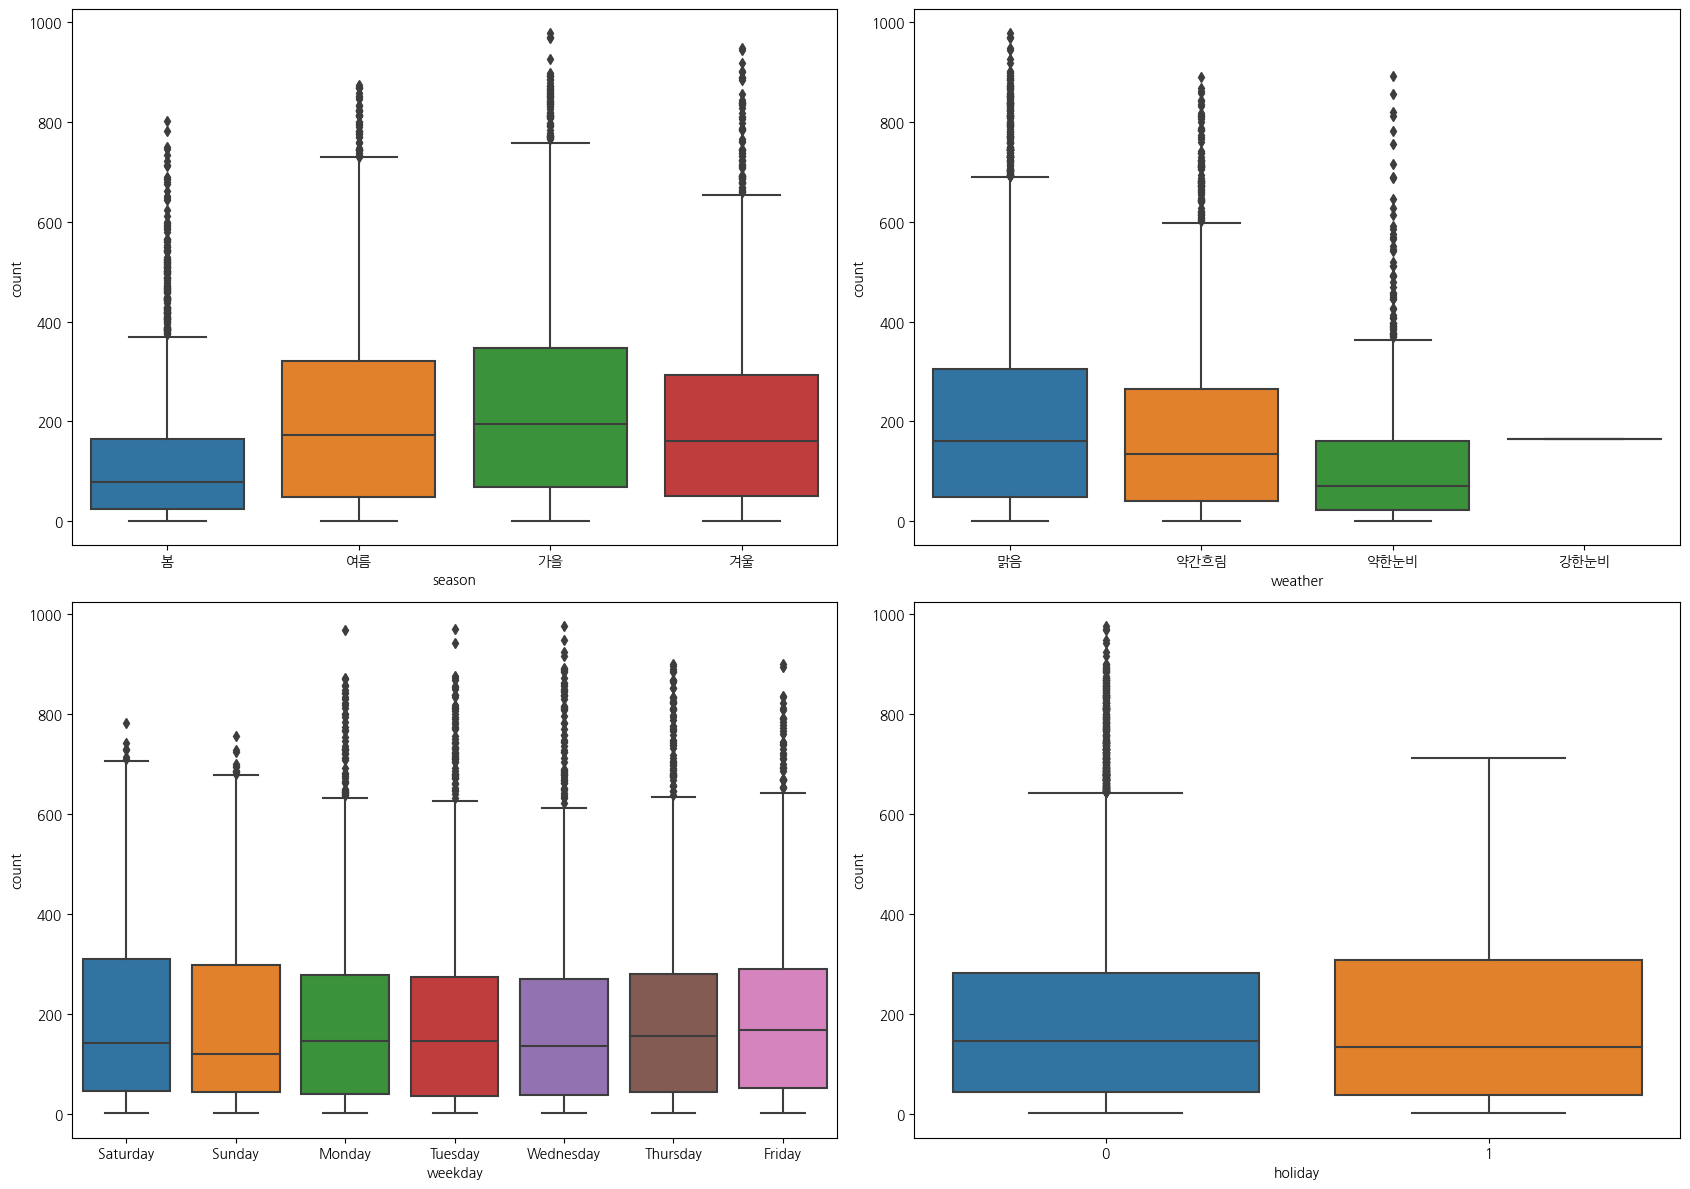

In [98]:
fig, ax = plt.subplots(nrows =2, ncols = 2, figsize=(17,12))
sns.boxplot(x = 'season', y = 'count', data = train, ax = ax[0,0])
sns.boxplot(x = 'weather', y = 'count', data = train, ax = ax[0,1])
sns.boxplot(x = 'weekday', y = 'count', data = train, ax = ax[1,0])
sns.boxplot(x = 'holiday', y = 'count', data = train, ax = ax[1,1])

plt.tight_layout()
plt.show()

박스 플롯 해석 결과 : weekday는 holiday workingday 상위개념이므로   
 머신러닝 독립변수는 적을 수록 좋으니 weekday만 살리는 것도 어떨지?**(개인적 견해)**

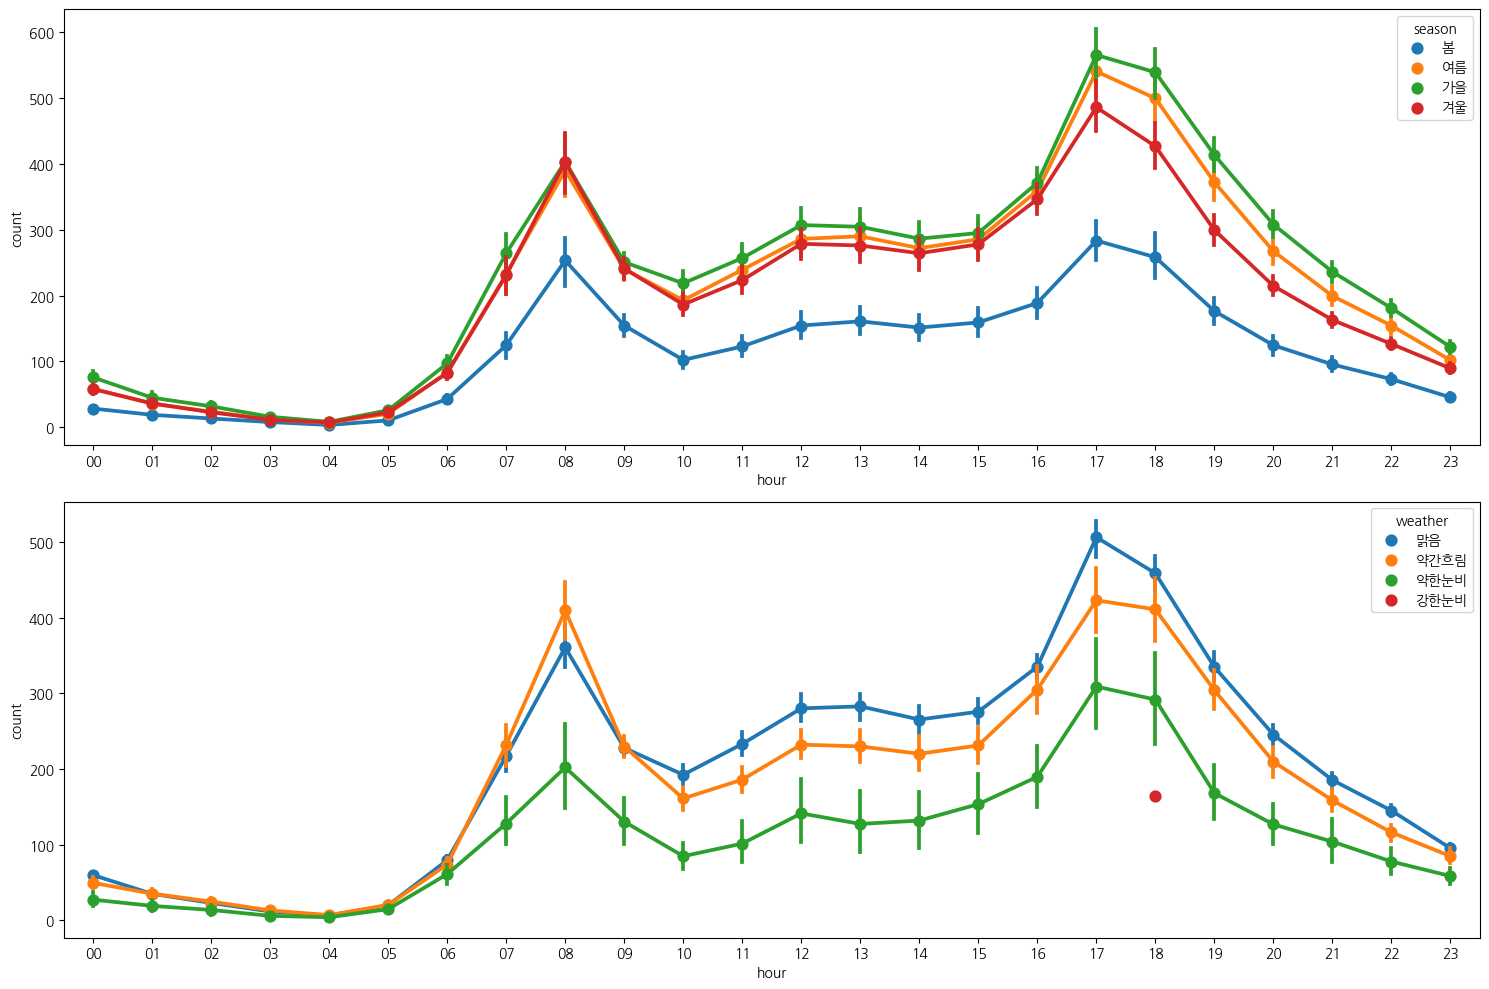

In [103]:
fig, ax = plt.subplots(nrows = 2, figsize=(15,10))
sns.pointplot(x = 'hour', y = 'count', hue = 'season', data = train, ax = ax[0])
sns.pointplot(x = 'hour', y = 'count', hue = 'weather', data = train, ax = ax[1])


plt.tight_layout()
plt.show()

In [104]:
train['weather'].value_counts()

맑음      7192
약간흐림    2834
약한눈비     859
강한눈비       1
Name: weather, dtype: int64

### 첫번째 확인 : 시스템 이상인가? => 1건이네? => PM님께 보고 => 개발자 확인 요청(보통 수정을 하겠지)
### 데이터 시각화로 해당 이상치를 잡아낸 것..!

# => 강한강우가 포함된 행은 제거로 결정.

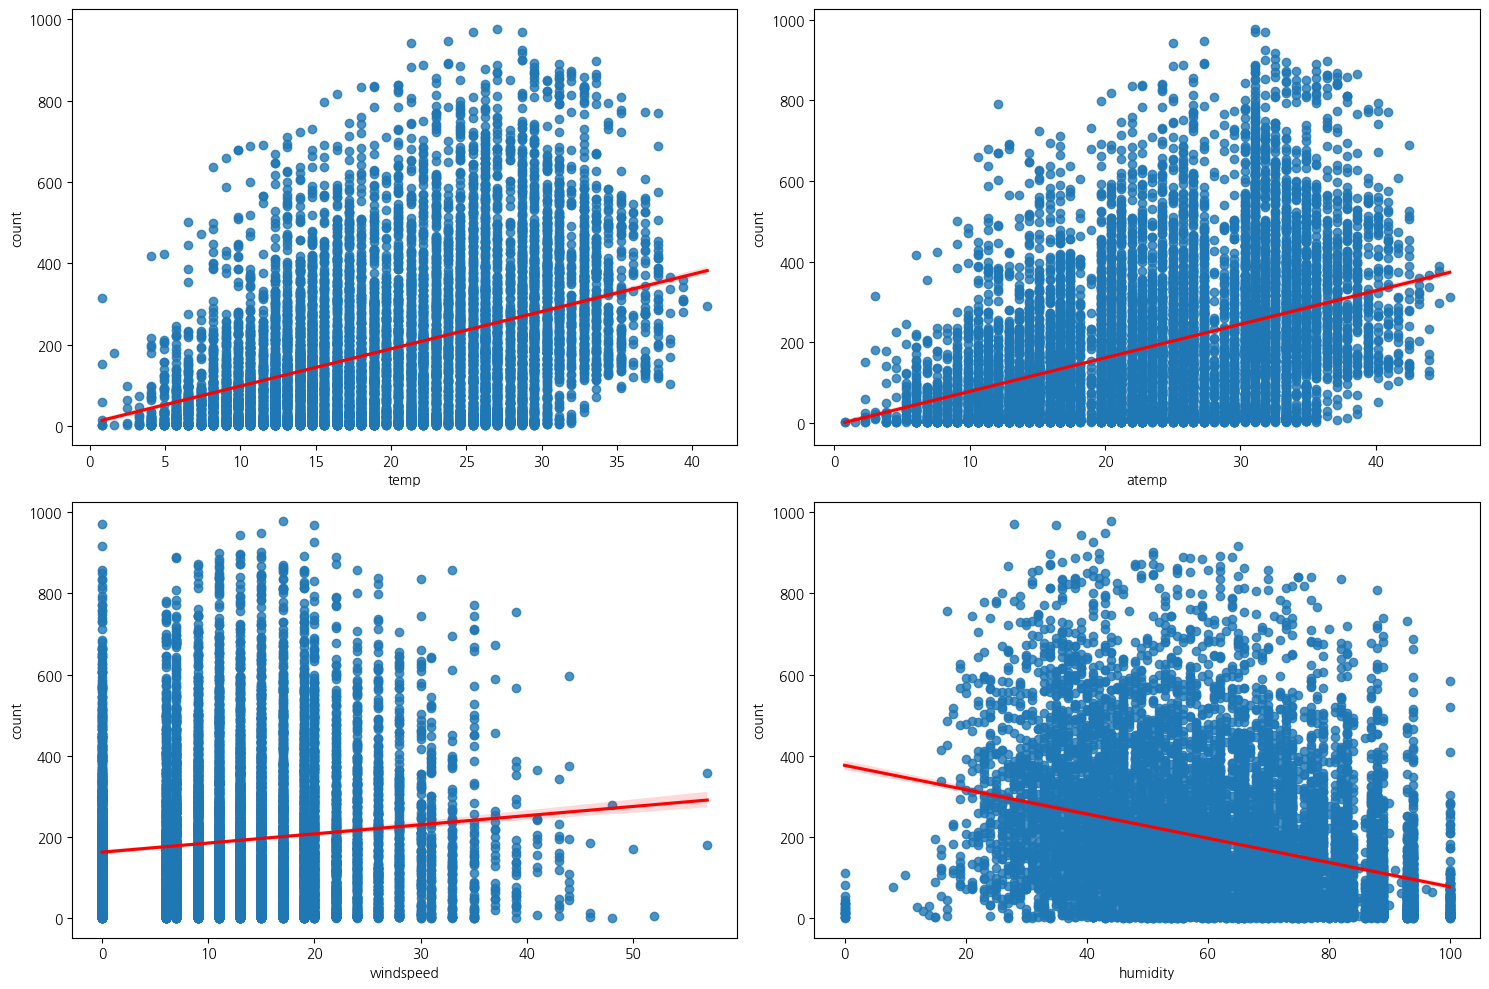

In [112]:
# 회귀식 과 산점도
# regplot() 사용
# 2 X 2
fig, ax = plt.subplots(nrows =2, ncols = 2, figsize=(15,10))
sns.regplot(x='temp', y='count', data=train, line_kws={'color': 'red'}, ax=ax[0, 0])
sns.regplot(x='atemp', y='count', data=train, line_kws={'color': 'red'}, ax=ax[0, 1])
sns.regplot(x='windspeed', y='count', data=train, line_kws={'color': 'red'}, ax=ax[1, 0])
sns.regplot(x='humidity', y='count', data=train, line_kws={'color': 'red'}, ax=ax[1, 1])


plt.tight_layout()
plt.show()

그래프를 고려했을 때, temp와 humidity 컬럼만 쓰도록 하겠다.
# 최종적인 input 변수 선정.

In [123]:
cols = ['temp', 'humidity', 'weather', 'weekday', 'count']
final_df = train.loc[train['weather'] != "강한눈비", cols]

print(final_df['weather'].value_counts())
print(final_df)

맑음      7192
약간흐림    2834
약한눈비     859
Name: weather, dtype: int64
        temp  humidity weather    weekday  count
0       9.84        81      맑음   Saturday     16
1       9.02        80      맑음   Saturday     40
2       9.02        80      맑음   Saturday     32
3       9.84        75      맑음   Saturday     13
4       9.84        75      맑음   Saturday      1
...      ...       ...     ...        ...    ...
10881  15.58        50      맑음  Wednesday    336
10882  14.76        57      맑음  Wednesday    241
10883  13.94        61      맑음  Wednesday    168
10884  13.94        61      맑음  Wednesday    129
10885  13.12        66      맑음  Wednesday     88

[10885 rows x 5 columns]
